# Mooney-Rivlin Hyperelasticity

## Overview

A Mooney-Rivlin hyperelastic material is one for which the derivatives of the free energy with respect to the invariants of stretch are constant.  The Mooney-Rivlin model

- a special case of the more general [polynomial hyperelastic model](PolynomialHyperelastic.ipynb)
- has 2 elastic constants, typically fit to uniaxial extension/compression, equibiaxial extension/compression, or shear experimental data
- usually valid for strains less than 100%

## See Also

- [User Defined Materials](UserMaterial.ipynb)
- [Linear Elastic Material](LinearElastic.ipynb)
- [Polynomial Hyperelastic Material](PolynomialHyperelastic.ipynb)

## Contents

1. <a href='#basic'>Fundamental Equations</a>
2. <a href='#implement'>Model Implementation</a>
3. <a href='#verify'>Model Verification</a>

In [1]:
%matmodlab

BokehJS successfully loaded.

Populating the interactive namespace from matmodlab and bokeh


<a name='basic'></a>
## Fundamental Equations

The Mooney-Rivlin material is a special case of the more general polynomial hyperelastic model defined by the following free energy potential

$$
a = c_{10}\left(\overline{I}_1 - 3\right) +  c_{01}\left(\overline{I}_2 - 3\right) 
  + \frac{1}{D_1}\left(J-1\right)^2
$$

where $c_{10}$, $c_{01}$, and $D_1$ are material parameters, the $\overline{I}_i$ are the isochoric invariants of the right Cauchy deformation tensor $C_{IJ} = F_{kI}F_{kJ}$, $F_{iJ}$ are the components of the deformation gradient tensor, and $J$ is the determinant of the deformation gradient.

### Second Piola-Kirchhoff Stress

The components of the second Piola-Kirchhoff stress $S_{IJ}$ are given by

$$
\frac{1}{2\rho_0} S_{IJ} = \frac{\partial a}{\partial C_{IJ}}
$$

For an isotropic material, the free energy $a$ is a function of $C_{IJ}$ through only its invariants, giving for $S_{IJ}$

$$
\frac{1}{2\rho_0}S_{IJ} 
       = \frac{\partial a}{\partial\overline{I}_1}\frac{\partial\overline{I}_1}{\partial C_{IJ}}
       + \frac{\partial a}{\partial\overline{I}_2}\frac{\partial\overline{I}_2}{\partial C_{IJ}}
       + \frac{\partial a}{\partial J}\frac{\partial J}{\partial C_{IJ}}
$$

The partial derivatives of the energy with respect to the invariants are

$$
\frac{\partial a}{\partial\overline{I}_1} = c_{10}, \quad
\frac{\partial a}{\partial\overline{I}_2} = c_{01}, \quad
\frac{\partial a}{\partial J} = \frac{2}{D_1}\left(J-1\right)
$$

and the partials of the invariants with respect to $C_{IJ}$ are

$$
\begin{align}
\frac{\partial\overline{I}_1}{\partial C_{IJ}}
 &= \frac{\partial\left( J^{-2/3} C_{KK}\right)}{\partial C_{IJ}} \\
 %&= \frac{\partial J^{-2/3}}{\partial C_{IJ}} I_1 + J^{-2/3} \frac{\partial C_{KK}}{\partial C_{IJ}} \\
 %&= -\frac{2}{3}J^{-5/3}\frac{\partial J}{\partial C_{IJ}} I_1 + J^{-2/3} \delta_{IJ} \\
 %&= -\frac{2}{3}J^{-5/3}\frac{1}{2}J C_{IJ}^{-1} I_1 + J^{-2/3} \delta_{IJ} \\
 &= J^{-2/3}\left(\delta_{IJ} - \frac{1}{3}I_1 C_{IJ}^{-1}\right) \\
\end{align}
$$

$$
\begin{align}
\frac{\partial\overline{I}_2}{\partial C_{IJ}}
 &= \frac{\partial\left( J^{-4/3}\left(C_{KK}^2 - C_{MN}C_{MN}\right)\right)}{\partial C_{IJ}} \\
 %&= \frac{\partial J^{-4/3}}{\partial C_{IJ}} \left(C_{KK}^2 - C_{MN}C_{MN}\right) + J^{-4/3} \frac{\partial \left(C_{KK}^2 - C_{MN}C_{MN}\right)}{\partial C_{IJ}} \\
 &= J^{-4/3}\left(I_1\delta_{IJ} - C_{IJ} - \frac{2}{3} I_2 C_{IJ}^{-1}\right) \\
\end{align}
$$

$$
\begin{align}
\frac{\partial J}{\partial C_{IJ}} &= \frac{\partial \sqrt{\det C_{KL}}}{\partial C_{IJ}} \\
%&= \frac{1}{2 \sqrt{\det C_{KL}}} \frac{\partial\det C_{KL}}{\partial C_{IJ}} \\
%&= \frac{1}{2 J} \frac{\partial\det C_{KL}}{\partial C_{IJ}} \\
&= \frac{1}{2} J C_{IJ}^{-1} \\
\end{align}
$$

Combining the above results, we arrive at the following expression for the components $S_{IJ}$:

$$
\frac{1}{2\rho_0}S_{IJ} 
   = c_{10}J^{-2/3}\left(\delta_{IJ} - \frac{1}{3}I_1 C_{IJ}^{-1}\right)
   + c_{01}J^{-4/3}\left(I_1\delta_{IJ} - C_{IJ} - \frac{2}{3} I_2 C_{IJ}^{-1}\right)
   + \frac{J}{D_1}\left(J-1\right) C_{IJ}^{-1}
$$

### Cauchy Stress

The components of the Cauchy stress tensor $\sigma_{ij}$ are given by the push-forward $S_{IJ}$:

$$
J \sigma_{ij} = F_{iM}S_{MN}F_{jN}
$$

$$
\begin{align}
\frac{J}{2\rho_0}\sigma_{ij} &= F_{iM}\left[
     c_{10}J^{-2/3}\left(\delta_{MN} - \frac{1}{3}I_1 C_{MN}^{-1}\right)
   + c_{01}J^{-4/3}\left(I_1\delta_{MN} - C_{MN} - \frac{2}{3} I_2 C_{MN}^{-1}\right)
   + \frac{J}{D_1}\left(J-1\right) C_{MN}^{-1}\right] F_{jN} \\
  &= c_{10}J^{-2/3}\left(F_{iN}F_{jN} - \frac{1}{3}I_1 F_{iM}C_{MN}^{-1}F_{jN}\right)
   + c_{01}J^{-4/3}\left(I_1F_{iN}F_{jN} - F_{iM}C_{MN}F_{jN} - \frac{2}{3} I_2 F_{iM}C_{MN}^{-1}F_{jN}\right) \\
   &\qquad + \frac{J}{D_1}\left(J-1\right) F_{iM}C_{MN}^{-1}F_{jN} \\
\end{align}
$$

Recognizing that

$$
C_{MN} = F_{kM}F_{kN} \Rightarrow C_{MN}^{-1} = F_{kN}^{-1}F_{kM}^{-1}
$$

the components of the Cauchy stress can be written as

$$
\begin{align}
\frac{J}{2\rho_0}\sigma_{ij} 
  &= c_{10}J^{-2/3}\left(F_{iN}F_{jN} - \frac{1}{3}I_1 F_{iM}F_{kN}^{-1}F_{kM}^{-1}F_{jN}\right)
   + c_{01}J^{-4/3}\left(I_1F_{iN}F_{jN} - F_{iM}F_{kM}F_{kN}F_{jN} - \frac{2}{3} I_2 F_{iM}F_{kN}^{-1}F_{kM}^{-1}F_{jN}\right) \\
   &\qquad + \frac{J}{D_1}\left(J-1\right) F_{iM}F_{kN}^{-1}F_{kM}^{-1}F_{jN} \\
  &= c_{10}J^{-2/3}\left(B_{ij} - \frac{1}{3}I_1 \delta_{ij} \right)
   + c_{01}J^{-4/3}\left(I_1B_{ij} - B_{ik}B_{kj} - \frac{2}{3} I_2 \delta_{ij}\right)
   + \frac{J}{D_1}\left(J-1\right) \delta_{ij} \\
  &= J^{-2/3} \left(c_{10} + c_{01}\overline{I}_1 \right)B_{ij}
   - c_{01}J^{-4/3}B_{ik}B_{kj}
  + \left(
      \frac{J}{D_1}\left(J-1\right)  - \frac{1}{3}\left(c_{10}\overline{I}_1 + c_{01}2\overline{I}_2\right)
    \right)\delta_{ij}
\end{align}
$$

where $B_{ij} = F_{iN}F_{jN}$ is the left Cauchy deformation tensor.  Finally, the components of the Cauchy stress are given by

$$
\begin{align}
\sigma_{ij} &= \frac{2\rho_0}{J} \left(
  J^{-2/3} \left(c_{10} + c_{01}\overline{I}_1 \right)B_{ij}
   - c_{01}J^{-4/3}B_{ik}B_{kj}\right)
  + \left(
      \frac{2\rho_0}{D_1}\left(J-1\right)  - \frac{2\rho_0}{3J}\left(c_{10}\overline{I}_1 + c_{01}2\overline{I}_2\right)
    \right)\delta_{ij} \\
&= \frac{2\rho_0}{J} \left(
  \left(c_{10} + c_{01}\overline{I}_1 \right)\overline{B}_{ij}
   - c_{01}\overline{B}_{ik}\overline{B}_{kj}\right)
  + \left(
      \frac{2\rho_0}{D_1}\left(J-1\right)  - \frac{2\rho_0}{3J}\left(c_{10}\overline{I}_1 + c_{01}2\overline{I}_2\right)
    \right)\delta_{ij} \\
\end{align}
$$

where $\overline{B}_{ij} = J^{-2/3}B_{ij}$

<a name='implement'></a>

## Matmodlab Implementation

Below, a Mooney-Rivlin material model is implemented as a standard Matmodlab material, subclassing the base `MaterialModel` class.  The model defines the following (required) attributes and methods

- `name`: name by which the model is referenced   
- `param_names`: method returning names of model parameters
- `update_state`: method the updates the material state
- `setup`: checks user input

Additionally, several helper functions are imported from various locations in Matmodlab:

- `matmodlab.utils.mmlabpack`

   - `det`, `inv`, `asarray`: computes the determinant and inverse of a second-order symmetric tensor stored as an array of length 6
   - `asarray`: converts a second-order symmetric tensor stored as a 3x3 matrix to an array of length 6
   
- `matmodlab.constants`
   - `I6`: Identity tensor stored as an array of length 6
   

### Loading the Material Model

Once defined in a computational cell, the material model is loaded in to Matmodlab through the `load_material` function using the `std_material` keyword.

In [2]:
import logging
from numpy import dot, zeros, trace, array, sum, eye
from matmodlab.mmd.material import MaterialModel
from matmodlab.utils.mmlabpack import asarray, det, inv
from matmodlab.constants import I6

class UserMooneyRivlin(MaterialModel):
    name = "umooneyrivlin"

    @classmethod
    def param_names(cls, n):
        return ['C10', 'C01', 'D1']

    def setup(self, **kwargs):
        """Set up the Mooney Rivlin material

        """
        logger = logging.getLogger('matmodlab.mmd.simulator')

        # Check inputs
        C10 = self.parameters['C10']
        C01 = self.parameters['C01']
        D1 = self.parameters['D1']

        errors = 0
        if D1 <= 0.:
            errors += 1
            logger.error('D1 must be > 0')

        G = 2. * (C10 + C01)
        if G <= 0:
            errors += 1
            logger.error('2 (C10 + C01) > 0')

        if errors:
            raise ValueError("stopping due to previous errors")

    def update_state(self, time, dtime, temp, dtemp, energy, rho, F0, F,
        stran, d, elec_field, stress, statev, **kwargs):
        """Compute updated stress given the updated deformation"""

        # elastic properties
        C10 = self.parameters['C10']
        C01 = self.parameters['C01']
        D1 = self.parameters['D1']

        # elastic stiffness
        ddsdde = None

        # Reshape the deformation gradient
        F = F.reshape(3,3)
        Jac = det(F)

        # left Cauchy deformation
        B = dot(F, F.T)
        Bsq = dot(B, B)

        incompressible = D1 > 1e4 * (C10 + C01)
        if incompressible:
            # enforce incompressibility
            Jac = 1

        # Invariants of B
        I1 = trace(B)
        I2 = .5 * (I1 ** 2 - trace(Bsq))

        # Invariants of Cbar
        scale = sign(abs(Jac) ** (1. / 3.), Jac)
        I1B = I1 / (scale ** 2)
        I2B = I2 / (scale ** 4)

        # convert symmetric tensors to arrays
        BBsq = asarray(Bsq, 6) / scale ** 4
        BB = asarray(B, 6) / scale ** 2

        if not incompressible:
            p = -2. / D1 * (Jac - 1.)
        else:
            p = 0.
        pb = p + 2. / 3. / Jac * (C10 * I1B + 2. * C01 * I2B)
        stress = 2. / Jac * ((C10 + C01 * I1B) * BB - C01 * BBsq) - pb * I6

        return stress, statev, ddsdde

def sign(x, y):
    return x if y > 0. else -x

load_material(UserMooneyRivlin)

<a name='verify'></a>
## Verification

### Uniaxial Stress

For an incompressible isotropic material, uniaxial stress is produced by the following deformation state

$$
[F] = \begin{bmatrix}\lambda && \\ & \frac{1}{\sqrt{\lambda}} & \\ & & \frac{1}{\sqrt{\lambda}} \end{bmatrix}
$$

The stress difference $\sigma_{\text{axial}} - \sigma_{\text{lateral}}$ is given by

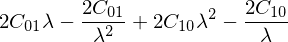

In [3]:
from sympy import Symbol, Matrix, Rational, symbols, sqrt
lam = Symbol('lambda')
F = Matrix(3, 3, [lam, 0, 0, 0, 1/sqrt(lam), 0, 0, 0, 1/sqrt(lam)])
B = Matrix(3, 3, F.dot(F.T))
Bsq = Matrix(3, 3, B.dot(B))
I = Matrix(3, 3, lambda i,j: 1 if i==j else 0)
I1 = B.trace()
I2 = ((B.trace()) ** 2 - Bsq.trace()) / 2
J = F.det()
X = J ** Rational(1, 3)
C1, C2, D1 = symbols('C10 C01 D1')
I1B = I1 / X ** 2
I2B = I2 / X ** 4

S = 2 / J * (1 / X ** 2 * (C1 + I1B * C2) * B - 1 / X ** 4 * C2 * Bsq) \
    + (2 / D1 * (J - 1) - 2 * (C1 * I1B + 2 * C2 * I2B) / 3) * I
(S[0,0] - S[1,1]).simplify()

We now exercise the Mooney-Rivlin material model using Matmodlab

In [4]:
# Hyperelastic parameters, D1 set to a large number to force incompressibility
parameters = {'D1': 1.e12, 'C10': 1e6, 'C01': .1e6}

# stretch to 300%
lam = linspace(.5, 3, 50)

# Set up the simulator
mps = MaterialPointSimulator('test1')
mps.Material('umooneyrivlin', parameters)

# Drive the *incompressible* material through a path of uniaxial stress by
# prescribing the deformation gradient.
Fij = lambda x: (x, 0, 0, 0, 1/sqrt(x), 0, 0, 0, 1/sqrt(x))
mps.DefGradStep(components=Fij(lam[0]), frames=10)
mps.DefGradStep(components=Fij(1), frames=1)
mps.DefGradStep(components=Fij(lam[-1]), frames=20)

# plot the analytic solution and the simulation
p = create_figure(x_axis_label='Stretch', y_axis_label='Stress')
C10, C01 = parameters['C10'], parameters['C01']

# analytic solution for true and engineering stress
s = 2*C01*lam - 2*C01/lam**2 + 2*C10*lam**2 - 2*C10/lam

# plot the analytic solutions
p.line(lam, s, color='blue', legend='True', line_width=2)
p.line(lam, s/lam, color='green', legend='Engineering', line_width=2)

lam_ = np.exp(mps.get('E.XX'))
ss = mps.get('S.XX') - mps.get('S.ZZ')
p.circle(lam_, ss, color='orange', legend='Simulation, True')
p.circle(lam_, ss/lam_, color='red', legend='Simulation, Engineering')
p.legend.location = 'top_left'

show(p)

# check the actual solutions
assert abs(amax(ss) - amax(s)) / amax(s) < 1e-6
assert abs(amin(ss) - amin(s)) < 1e-6